In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

datadir='../data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

## Simulations

In [3]:
simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key='USDOLLAR')

policies = [cp.PeriodicRebalance(target=w_b, period=p) for p in ['day', 'week', 'month', 'quarter', 'year']]
policies.append(cp.Hold())

res = pd.DataFrame(index=['Daily','Weekly','Monthly','Quarterly','Annually','Hold'])
for label, fund_val in [('\$100M',1E8), ('\$10B',1E10)]:
    res[label] = simulator.run_multiple_backtest(fund_val*w_b, start_time=start_t, end_time=end_t, 
                                                 policies=policies, parallel=True)

## Results 

In [6]:
used_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)]
benchmark_returns = pd.Series(index=used_returns.index, data=np.dot(used_returns.values, w_b.values))

table=pd.DataFrame()
table[r'Active return']=res.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Active risk']= \
    res.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
table[r'Trans. costs']=\
    res.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()
table[r'Turnover']= \
    res.applymap(lambda res: res.turnover.mean()*100.*250.).unstack()


table_print=pd.DataFrame(table,copy=True)
table_print.iloc[:,:]=table_print.iloc[:,:].applymap(lambda x: r'%.2f%%'%x )
table_print

Active return Active risk Trans. costs Turnover
\$100M Daily            -0.08%       0.00%        0.08%  222.15%
       Weekly           -0.07%       0.09%        0.04%  106.43%
       Monthly          -0.13%       0.22%        0.02%   53.07%
       Quarterly        -0.12%       0.36%        0.01%   30.17%
       Annually         -0.06%       0.66%        0.01%   12.60%
       Hold             -0.23%       1.63%        0.00%    0.00%
\$10B  Daily            -0.25%       0.01%        0.25%  222.15%
       Weekly           -0.19%       0.09%        0.16%  106.44%
       Monthly          -0.21%       0.22%        0.11%   53.07%
       Quarterly        -0.18%       0.36%        0.08%   30.18%
       Annually         -0.09%       0.66%        0.05%   12.61%
       Hold             -0.23%       1.63%        0.00%    0.00%

# Plots 

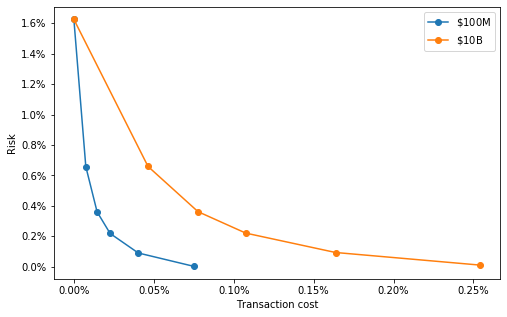

In [7]:
plt.figure(figsize=(8,5))
for v1 in table.index.levels[0][:]:
    x = table.loc[v1]['Trans. costs']
    y = table.loc[v1]['Active risk']
    plt.plot(np.array(x),np.array(y), 'o-', label='$%s\mathrm{%s}$'%(v1[:-1],v1[-1:]))
plt.legend(loc='upper right')
plt.xlabel('Transaction cost')
plt.ylabel('Risk')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f%%'))
plt.savefig('basic_frontier.png')